In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
import io

In [11]:
# Load the data
df = pd.read_csv('ncaab_2023_24_cleaned.csv')
print("Data loaded successfully!")
print(f"Dataset contains {len(df)} teams with {len(df.columns)} statistics per team.")
print("\n" + "="*80 + "\n")

Data loaded successfully!
Dataset contains 362 teams with 26 statistics per team.




In [13]:
# Define the features we'll use for prediction
features = [
    'W-L%', 'SRS', 'SOS', 'FG%', '3P%', 'FT%', 
    'TRB', 'AST', 'STL', 'BLK', 'TOV'
]
print("Selected features for prediction:")
for feature in features:
    print(f"- {feature}")
print("\n" + "="*80 + "\n")

Selected features for prediction:
- W-L%
- SRS
- SOS
- FG%
- 3P%
- FT%
- TRB
- AST
- STL
- BLK
- TOV




<center><h5><strong>Understanding the Tournament Prediction Code Structure</strong></h5></center>
    
This code follows a modular design pattern common in Python analytics projects. Each major component is encapsulated within a function, making the code reusable and well-organized. The program starts by defining these specialized functions (each beginning with def), which are like recipes waiting to be used. For example, normalize_features() standardizes statistical data, generate_synthetic_matchups() creates training examples, train_model() builds the prediction model, and create_summary_visualization() prepares the visual output. None of these functions execute when defined - they're simply stored for later use. 

The actual execution happens in the main() function, which orchestrates the entire analysis by calling these functions in sequence. Finally, the if __name__ == "__main__": conditional statement serves as the trigger mechanism - it only executes the main() function when the script is run directly (rather than being imported elsewhere). This structure ensures that all components are properly defined before any analysis begins, and allows the same code to be either run as a standalone program or imported into other projects as a module.

In [16]:
# Create a function to normalize features
def normalize_features(df, features):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled, scaler

# Apply normalization
df_scaled, scaler = normalize_features(df, features)

Normalization is crucial for logistic regression. Since our features have different units and scales (percentages, counts, etc.), we standardize them to have mean=0 and standard deviation=1. This ensures all features contribute proportionally to the model regardless of their original scale. 

For example, without normalization, statistics with larger values (like total rebounds) would numerically dominate statistics with smaller values (like shooting percentages).

In [19]:
# Function to create synthetic matchups for training
def generate_synthetic_matchups(df, features, n_matchups=10000):
    matchups = []
    
    for _ in range(n_matchups):
        # Select two random teams
        team_indices = np.random.choice(len(df), 2, replace=False)
        team_a = df.iloc[team_indices[0]]
        team_b = df.iloc[team_indices[1]]
        
        # Calculate statistical differences
        diff_features = {}
        for feature in features:
            diff_features[f"{feature}_diff"] = team_a[feature] - team_b[feature]
        
        # Determine simulated winner based on SRS difference
        srs_diff = team_a['SRS'] - team_b['SRS']
        win_prob_a = 1 / (1 + np.exp(-0.2 * srs_diff))  # logistic function
        winner = 1 if np.random.random() < win_prob_a else 0
        
        matchups.append({
            'team_a': team_a['School'],
            'team_b': team_b['School'],
            **diff_features,
            'winner': winner
        })
    
    return pd.DataFrame(matchups)

# Generate the synthetic matchups
matchups_df = generate_synthetic_matchups(df_scaled, features)

Since we don't have labeled historical data of head-to-head matchups with outcomes, we create synthetic training data. This function:

- Randomly selects pairs of teams
- Calculates the difference in each feature between the teams
- Uses the SRS difference (a reliable overall team strength metric) to estimate a win probability
- Probabilistically assigns a winner based on this probability
- Repeats to create 10,000 synthetic matchups (this number is up to the researcher)

This approach creates realistic training data that captures the relationship between statistical differences and game outcomes.

In [21]:
# Function to train the logistic regression model
def train_model(matchup_df, features):
    X_cols = [f"{feature}_diff" for feature in features]
    X = matchup_df[X_cols]
    y = matchup_df['winner']
    
    model = LogisticRegression(random_state=42)
    model.fit(X, y)
    
    return model

# Train the model
model = train_model(matchups_df, features)

Logistic regression is ideal for this task because:

- It predicts probabilities for binary outcomes (win/loss)
- It works well with the "difference" approach (Team A stat - Team B stat)
- The coefficients tell us which statistical differences most strongly predict winning

The model learns to estimate the probability that Team A will beat Team B based on the statistical differences between them.

In [23]:
# Function to predict the winner of a specific matchup
def predict_matchup(team_a_name, team_b_name, df, model, features):
    # Get team data
    team_a = df[df['School'] == team_a_name].iloc[0]
    team_b = df[df['School'] == team_b_name].iloc[0]
    
    # Calculate feature differences
    diff_features = {}
    for feature in features:
        diff_features[f"{feature}_diff"] = team_a[feature] - team_b[feature]
    
    # Create DataFrame with feature differences
    X_pred = pd.DataFrame([diff_features])
    
    # Predict probability
    prob = model.predict_proba(X_pred)[0][1]
    
    return {
        'team_a': team_a_name,
        'team_b': team_b_name,
        'team_a_win_probability': prob,
        'team_b_win_probability': 1 - prob,
        'predicted_winner': team_a_name if prob > 0.5 else team_b_name,
        'feature_differences': diff_features
    }

This function applies our trained model to predict the outcome of any specific matchup:

- It finds both teams in our dataset to get their statistics
- Calculates the differences in each feature (Team A - Team B)
- Feeds these differences into our logistic regression model
- Returns both the win probability and predicted winner

This approach treats every matchup as "Team A vs Team B" and predicts the probability that Team A wins. 

'predicted_winner': team_a_name if prob > 0.5 else team_b_name,This line determines the predicted winner based on whether Team A's win probability is greater than 50%. If it's not, then Team B is predicted to win.

In [25]:
import difflib  # For finding string similarities

# Function to find the closest team name match
def find_closest_team(team_name, team_list):
    """
    Find the closest matching team name in the team_list
    using string similarity comparison.
    
    Args:
        team_name (str): The team name to look for
        team_list (list): List of available team names
    
    Returns:
        str: The closest matching team name from the list
    """
    # Use difflib to find the closest match
    closest_match = difflib.get_close_matches(team_name, team_list, n=1, cutoff=0.6)
    
    # Return the closest match if found, otherwise return the original name
    if closest_match:
        return closest_match[0]
    else:
        # If no good match found, return the first team as a fallback
        return team_list[0] if team_list else team_name


# Function to predict multiple matchups
def predict_multiple_matchups(matchup_list, df, model, features):
    results = {}
    
    print("\nSweet 16 Predictions (Who Makes Elite 8):")
    print("=" * 80)
    
    for idx, (team_a, team_b) in enumerate(matchup_list):
        # Check if teams exist in dataset
        if team_a not in df['School'].values:
            closest_match = find_closest_team(team_a, df['School'].tolist())
            print(f"Warning: '{team_a}' not found. Using closest match: '{closest_match}'")
            team_a = closest_match
            
        if team_b not in df['School'].values:
            closest_match = find_closest_team(team_b, df['School'].tolist())
            print(f"Warning: '{team_b}' not found. Using closest match: '{closest_match}'")
            team_b = closest_match
            
        # Get prediction
        prediction = predict_matchup(team_a, team_b, df, model, features)
        
        # Store prediction
        results[f"matchup_{idx+1}"] = prediction
        
        # Print results
        print(f"\nMatchup {idx+1}: {team_a} vs {team_b}")
        print(f"{team_a} win probability: {prediction['team_a_win_probability']:.2%}")
        print(f"{team_b} win probability: {prediction['team_b_win_probability']:.2%}")
        print(f"Predicted to advance: {prediction['predicted_winner']}")
        print("-" * 80)
    
    return results

Explanation: This function handles processing a list of matchups:

- It iterates through each matchup pair (Team A, Team B)
- Handles cases where team names might not exactly match the dataset
- Gets a prediction for each matchup
- Stores all predictions in a dictionary
- Prints the results for each matchup

This approach lets us efficiently process all 8 Sweet 16 matchups at once.

In [27]:
# Create a combined visualization of all predictions
def create_summary_visualization(all_predictions, show_in_console=True):
    """Create a single image with all matchup predictions and display in console"""
    num_matchups = len(all_predictions)
    
    # Determine grid layout (4 columns, 4 rows for 16 matchups)
    cols = 4
    rows = (num_matchups + cols - 1) // cols
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # Flatten axes for easy iteration
    axes = axes.flatten() if num_matchups > 1 else [axes]
    
    # Create charts in each subplot
    for i, matchup_key in enumerate(sorted(all_predictions.keys())):
        if i >= len(axes):
            break
            
        prediction = all_predictions[matchup_key]
        ax = axes[i]
        
        team_a = prediction['team_a']
        team_b = prediction['team_b']
        prob_a = prediction['team_a_win_probability']
        prob_b = prediction['team_b_win_probability']
        
        # Team colors dictionary
        team_colors = {
            'Auburn':         '#E87722',  # Auburn Orange
            'Michigan':       '#00274C',  # Michigan Blue
            'Mississippi':    '#C8102E',  # Ole Miss Cardinal
            'Michigan State': '#18453B',  # Spartan Green
            'Florida':        '#0021A5',  # Florida Blue
            'Maryland':       '#E03C31',  # Maryland Red
            'Texas Tech':     '#CC0000',  # Texas Tech Red
            'Arkansas':       '#000000',  # Arkansas Black
            'Arizona':        '#CC0033',  # Arizona Red
            'Duke':           '#001D70',  # Duke Blue
            'Brigham Young':  '#002E5D',  # BYU Blue
            'Alabama':        '#9E1B32',  # Alabama Crimson
            'Purdue':         '#FFB81C',  # Purdue Old Gold
            'Houston':        '#BF0A30',  # Houston Red
            'Kentucky':       '#0033A0',  # Kentucky Blue
            'Tennessee':      '#FF8200'   # Tennessee Orange
}

        
        # Create donut chart
        wedges, texts = ax.pie(
            [prob_a, prob_b], 
            wedgeprops=dict(width=0.4), 
            startangle=90,
            colors=[team_colors.get(team_a, '#1f77b4'), team_colors.get(team_b, '#ff7f0e')]
        )
        
        # Add title and predicted winner
        ax.set_title(f'{team_a} vs {team_b}', fontsize=10)
        predicted_winner = prediction['predicted_winner']
        ax.text(0, 0, f"{predicted_winner}\n{prob_a:.0%} - {prob_b:.0%}", 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Hide any unused subplots
    for i in range(num_matchups, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Show the figure in the console if requested
    if show_in_console:
        print("Displaying all matchup predictions in console...")
        plt.show()
    else:
        plt.close()

Explanation: This function creates a visual representation of all our predictions:

It sets up a grid of subplots (4 columns x 4 rows for 16 matchups) For each matchup, it creates a donut chart showing the win probabilities It shows the team names, probabilities, and predicted winner for each matchup The visualization uses team colors, making it more engaging All predictions are displayed together for easy comparison.

Visualizations make the predictions more accessible and help identify patterns across multiple matchups.

In [34]:
# Function to display projected Elite 8
def display_projected_elite_8(all_predictions):
    """Display the projected Elite 8 teams based on Sweet 16 predictions"""
    projected_elite_8 = {}
    
    # Group by regions
    regions = ["East", "West", "South", "Midwest"]
    
    # Map matchups to regions
    region_mapping = {
        1: "East", 2: "East",
        3: "West", 4: "West",
        5: "South", 6: "South",
        7: "Midwest", 8: "Midwest"
    }
    
    # Get all predicted winners from Sweet 16
    for key, prediction in all_predictions.items():
        matchup_num = int(key.split('_')[1])
        region = region_mapping[matchup_num]
        
        if region not in projected_elite_8:
            projected_elite_8[region] = []
            
        projected_elite_8[region].append(prediction['predicted_winner'])
    
    # Print the projected Elite 8 by region
    print("\nProjected Elite 8 Teams:")
    print("=" * 80)
    
    for region in regions:
        if region in projected_elite_8:
            print(f"\n{region} Region:")
            for i, team in enumerate(projected_elite_8[region], 1):
                print(f"  {i}. {team}")
    
    return projected_elite_8

Explanation: This function organizes our predictions by tournament region:

- It creates a mapping of matchup numbers to tournament regions
- For each predicted winner, it adds them to the appropriate region's list
- It displays the projected Elite 8 teams organized by region

This makes our output match the tournament structure and allows for easier comparison with the actual results.

Predicting Which Teams Will Advance to Elite 8 from Sweet 16

Sweet 16 Predictions (Who Makes Elite 8):

Matchup 1: Duke vs Arizona
Duke win probability: 48.22%
Arizona win probability: 51.78%
Predicted to advance: Arizona
--------------------------------------------------------------------------------

Matchup 2: Brigham Young vs Alabama
Brigham Young win probability: 49.33%
Alabama win probability: 50.67%
Predicted to advance: Alabama
--------------------------------------------------------------------------------

Matchup 3: Florida vs Maryland
Florida win probability: 52.88%
Maryland win probability: 47.12%
Predicted to advance: Florida
--------------------------------------------------------------------------------

Matchup 4: Texas Tech vs Arkansas
Texas Tech win probability: 55.23%
Arkansas win probability: 44.77%
Predicted to advance: Texas Tech
--------------------------------------------------------------------------------

Matchup 5: Auburn vs Michigan
Auburn win probability

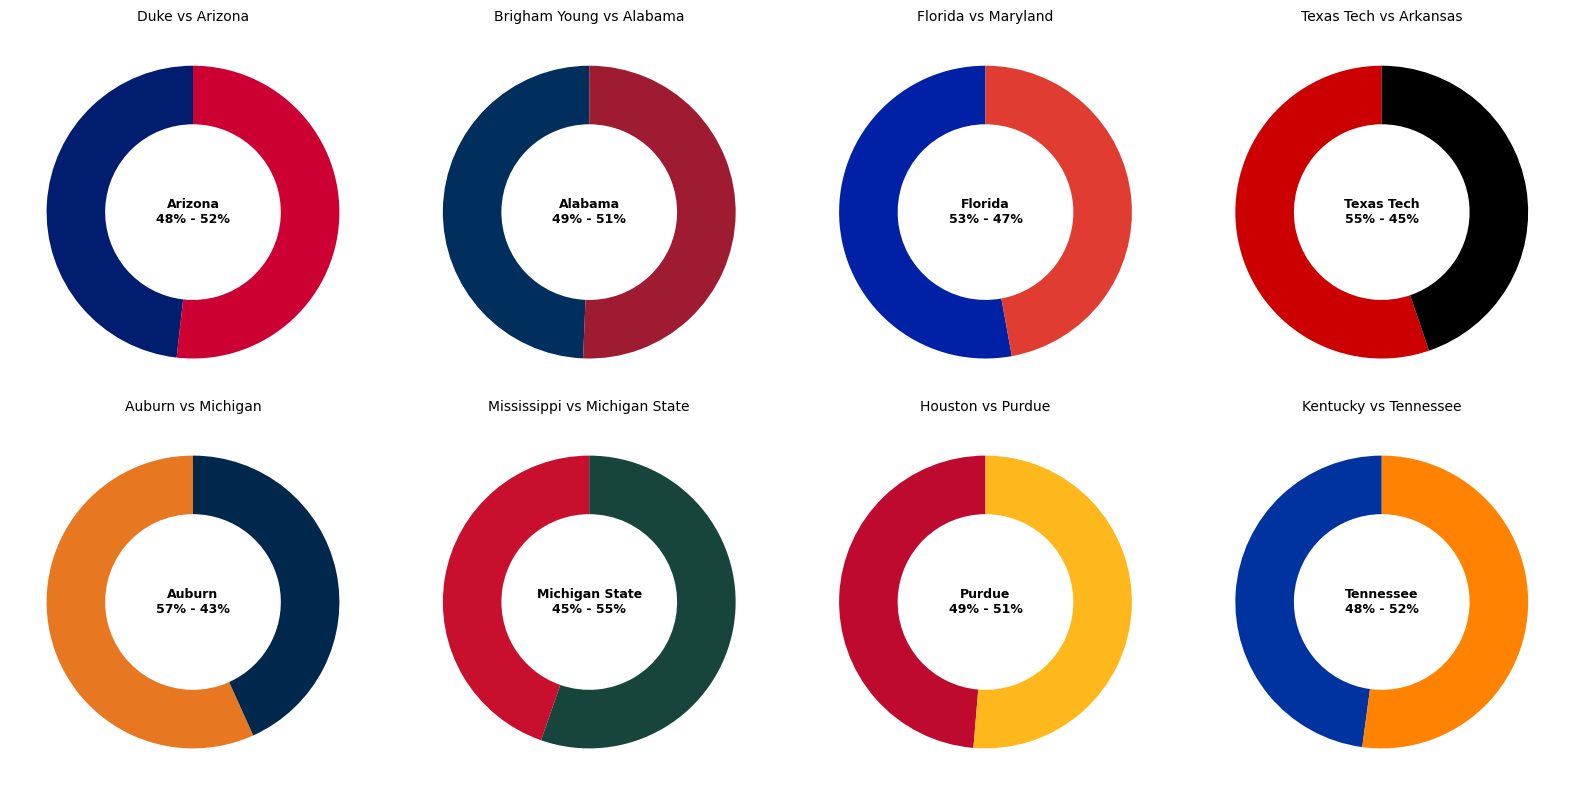


Projected Elite 8 Teams:

East Region:
  1. Arizona
  2. Alabama

West Region:
  1. Florida
  2. Texas Tech

South Region:
  1. Auburn
  2. Michigan State

Midwest Region:
  1. Purdue
  2. Tennessee


In [45]:
# Main execution - 2025 NCAA Tournament Sweet 16 Predictions
def main():
    # Define the actual Sweet 16 teams for the 2025 NCAA Tournament
    sweet_16_matchups = [
        # East Regional
        ('Duke', 'Arizona'),
        ('Brigham Young', 'Alabama'),
        
        # West Regional
        ('Florida', 'Maryland'),
        ('Texas Tech', 'Arkansas'),
        
        # South Regional
        ('Auburn', 'Michigan'),
        ('Mississippi', 'Michigan State'),
        
        # Midwest Regional
        ('Houston', 'Purdue'),
        ('Kentucky', 'Tennessee')
    ]
    
    print("Predicting Which Teams Will Advance to Elite 8 from Sweet 16")
    print("=" * 80)
    
    # Generate predictions for all matchups
    all_predictions = predict_multiple_matchups(sweet_16_matchups, df_scaled, model, features)
    
    # Create and display a summary visualization in the console
    create_summary_visualization(all_predictions)
    
    # Display projected Elite 8
    projected_elite_8 = display_projected_elite_8(all_predictions)

if __name__ == "__main__":
    main()